In [26]:
import sys
import os
import plotly.graph_objects as go
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
sys.path.append(os.path.abspath(".."))

from Data.DatabaseConnection import DatabaseConnection
dotenv_path = os.path.abspath("../.env")  
db = DatabaseConnection(dotenv_path)
players = db.get_all_players()
df = pd.DataFrame(players, columns=['puuid','match_id', 'placement', 'level', 'gold_left', 'last_round', 'players_eliminated', 'time_eliminated', 'total_damage', 'companion_id', 'tier', 'division', 'leaguepoints', 'wins', 'losses'])
df.head()

,puuid,match_id,placement,level,gold_left,last_round,players_eliminated,time_eliminated,total_damage,companion_id,tier,division,leaguepoints,wins,losses
0,teSxaW593i5isCS3TUX-dWR3JbmVaFZ0mc5bqkK1j-TtVn...,EUN1_3778549380,3,9,1,38,0,2177.756592,157,d401983f-04c9-4809-a1f4-d995a9ab6091,BRONZE,III,93,3,2
1,Ud8sd5s8jE_5bpv4rpb0-BRvayXhHJXKbi0eB1jue8iJxO...,EUN1_3778549380,5,8,30,33,0,1909.064697,68,05e285f5-7d09-4126-9643-da31b1bd2193,BRONZE,II,84,8,15
2,DdLDFxWyhuQTyuZMhQJaL4ZWS5ymGEa0BTgIvXXYS9u53x...,EUN1_3778549380,2,9,1,40,2,2270.521240,184,96c29152-c710-4f05-85c0-32eb73bef7c0,GOLD,IV,76,30,33
3,r6sJI0-vHg3NbXZ5rv92BM342jeKGm2oFpIzNQUAneQkic...,EUN1_3778549380,6,7,3,28,0,1647.791016,65,f152e2a3-6751-42e5-a911-ef029d5a8bff,SILVER,III,86,20,29
4,x0Ze-ORBYyEFKumY3rTDvSORTwnZTM9xnXUECY3Thm3hWV...,EUN1_3778549380,1,10,4,40,3,2270.521240,187,27f5bf5a-7183-4efa-b065-86ff9b8c0fb1,PLATINUM,II,57,33,19


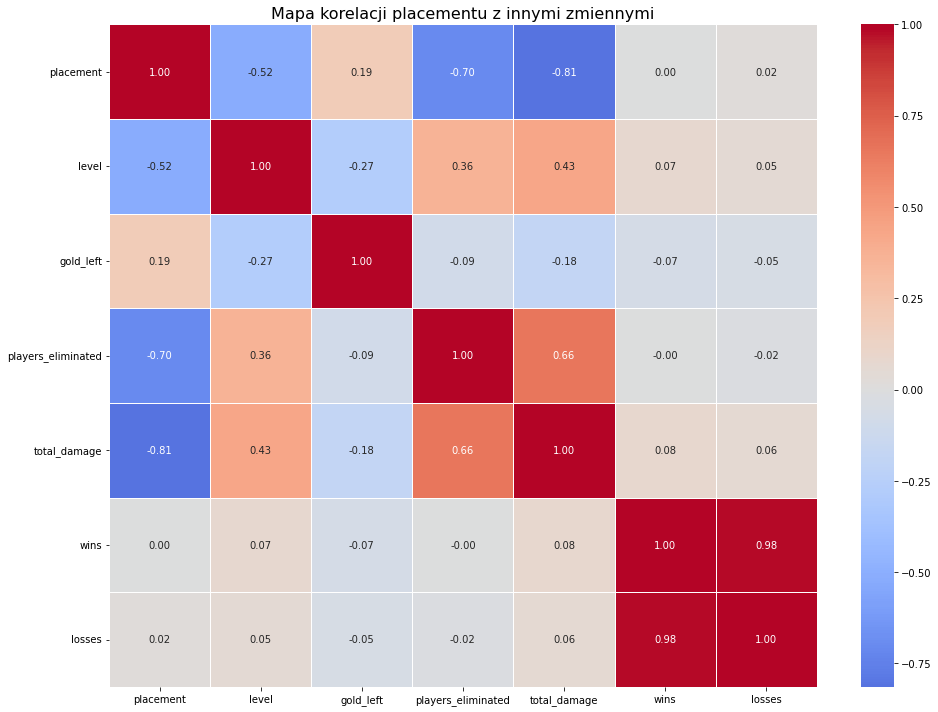

In [27]:
corr_data = df[['placement', 'level', 'gold_left', 'players_eliminated', 'total_damage', 'wins', 'losses']].dropna()

corr_matrix = corr_data.corr(numeric_only=True)

plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f", linewidths=0.5)
plt.title('Mapa korelacji placementu z innymi zmiennymi', fontsize=16)
plt.tight_layout()
plt.show()


/tmp/ipykernel_13808/3247139241.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



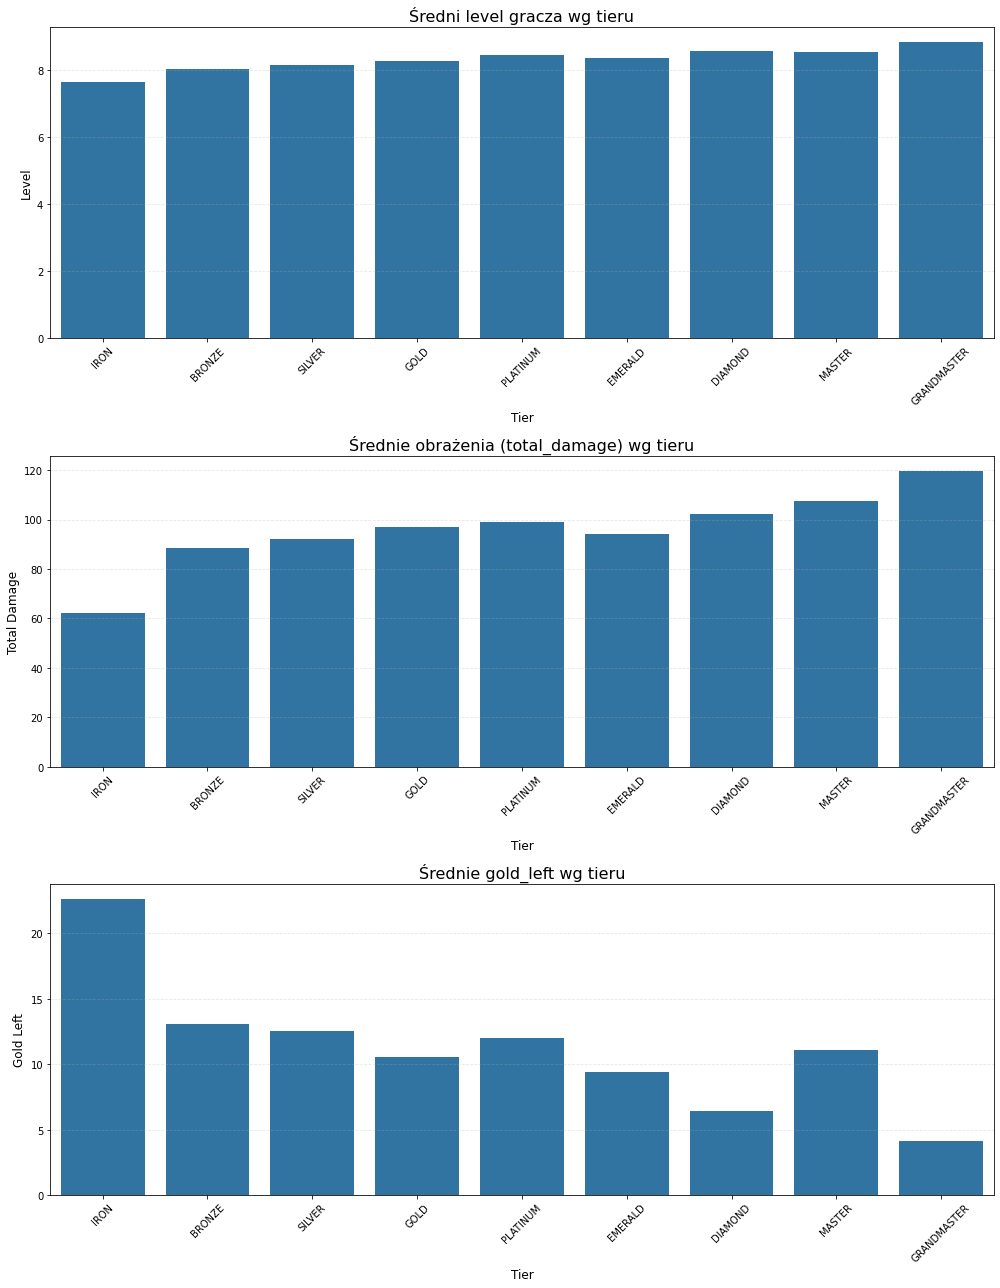

In [28]:
style_data = df[['tier', 'level', 'total_damage', 'gold_left']].dropna()

tier_order = ['IRON', 'BRONZE', 'SILVER', 'GOLD', 'PLATINUM', 'EMERALD', 'DIAMOND', 'MASTER', 'GRANDMASTER']
style_data['tier'] = pd.Categorical(style_data['tier'], categories=tier_order, ordered=True)

tier_grouped = style_data.groupby('tier').mean(numeric_only=True).reset_index()

plt.figure(figsize=(14, 18))

plt.subplot(3, 1, 1)
sns.barplot(data=tier_grouped, x='tier', y='level', order=tier_order)
plt.title("Średni level gracza wg tieru", fontsize=16)
plt.xlabel("Tier", fontsize=12)
plt.ylabel("Level", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.subplot(3, 1, 2)
sns.barplot(data=tier_grouped, x='tier', y='total_damage', order=tier_order)
plt.title("Średnie obrażenia (total_damage) wg tieru", fontsize=16)
plt.xlabel("Tier", fontsize=12)
plt.ylabel("Total Damage", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.subplot(3, 1, 3)
sns.barplot(data=tier_grouped, x='tier', y='gold_left', order=tier_order)
plt.title("Średnie gold_left wg tieru", fontsize=16)
plt.xlabel("Tier", fontsize=12)
plt.ylabel("Gold Left", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()




In [29]:
win_stats = df.groupby('tier')[['wins', 'losses']].sum().reset_index()

win_stats = win_stats[win_stats['tier'].str.upper() != 'UNRANKED']

win_stats['winrate'] = win_stats['wins'] / (win_stats['wins'] + win_stats['losses'])
win_stats = win_stats.sort_values('winrate', ascending=False)

fig = go.Figure()

for i, row in enumerate(win_stats.itertuples()):
    fig.add_trace(go.Indicator(
        mode="gauge+number+delta",
        value=row.winrate * 100,
        delta={'reference': 50, 'increasing': {'color': "green"}, 'decreasing': {'color': "red"}},
        gauge={
            'axis': {'range': [0, 100]},
            'bar': {'color': 'darkblue'},
            'steps': [
                {'range': [0, 50], 'color': "#f99"},
                {'range': [50, 100], 'color': "#9f9"}
            ]
        },
        title={'text': f"{row.tier}"},
        domain={'row': i // 3, 'column': i % 3}
    ))

fig.update_layout(
    grid={'rows': (len(win_stats) + 2) // 3, 'columns': 3, 'pattern': "independent"},
    title="Winrate graczy według tieru (Gauge Style)",
    height=400 + 200 * ((len(win_stats) + 2) // 3)
)

fig.show()


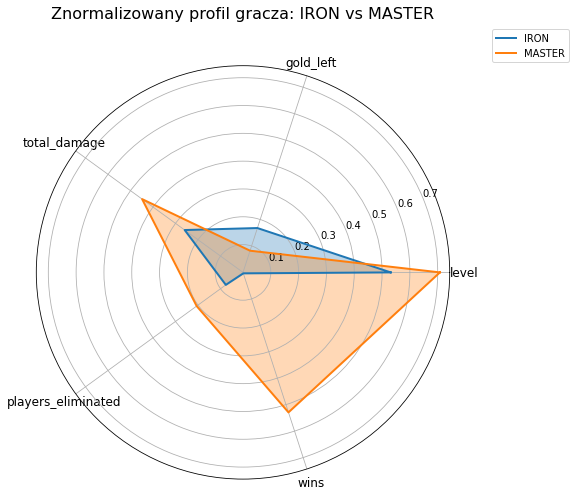

In [30]:
from sklearn.preprocessing import MinMaxScaler

radar_features = ['level', 'gold_left', 'total_damage', 'players_eliminated', 'wins']
tier_1 = 'IRON'
tier_2 = 'MASTER'

group1 = df[df['tier'].str.upper() == tier_1][radar_features]
group2 = df[df['tier'].str.upper() == tier_2][radar_features]

group1['tier'] = tier_1
group2['tier'] = tier_2

combined = pd.concat([group1, group2])
scaler = MinMaxScaler()
scaled = scaler.fit_transform(combined[radar_features])
scaled_df = pd.DataFrame(scaled, columns=radar_features)
scaled_df['tier'] = combined['tier'].values

mean_1 = scaled_df[scaled_df['tier'] == tier_1][radar_features].mean().values
mean_2 = scaled_df[scaled_df['tier'] == tier_2][radar_features].mean().values

categories = radar_features
N = len(categories)
angles = [n / float(N) * 2 * np.pi for n in range(N)] + [0]

values_1 = np.append(mean_1, mean_1[0])
values_2 = np.append(mean_2, mean_2[0])

plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)
plt.xticks(angles[:-1], categories, fontsize=12)

ax.plot(angles, values_1, label=tier_1, linewidth=2)
ax.fill(angles, values_1, alpha=0.3)

ax.plot(angles, values_2, label=tier_2, linewidth=2)
ax.fill(angles, values_2, alpha=0.3)

plt.title(f"Znormalizowany profil gracza: {tier_1} vs {tier_2}", size=16, y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()


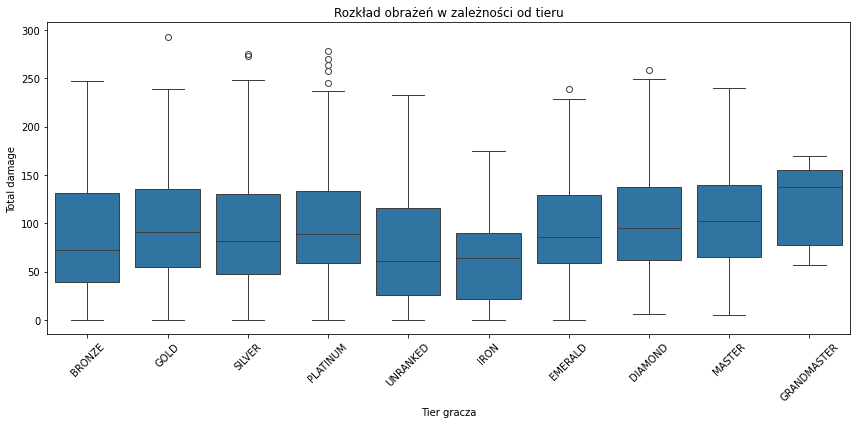

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='tier', y='total_damage')
plt.title("Rozkład obrażeń w zależności od tieru")
plt.xlabel("Tier gracza")
plt.ylabel("Total damage")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()